<a href="https://colab.research.google.com/github/Haraguchi-T/minicomp-codes/blob/main/rev_simple_unsloth_sft%EF%BC%8BDrgrpo_2048_verify_plus_Groq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GRPOを行うためのシンプルなコード

GRPOとはLLMにオンライン強化学習の一種です．
以下が簡単なフロー解説になります．

１．まず学習対象のモデルである問題に対して複数生成します．(同じプロンプトで複数回生成する)

２．次に生成した各サンプルの解答を答え合わせします．あっていたら1点，間違っていたら0点を振ります．それ以外にも同時に色々なポイント(報酬)を与えます．

３．次に各生成サンプルの報酬を"相対化(報酬分布の正規化)"します．

４．最後に計算された相対的な報酬を元に勾配を更新(モデルパラメータの更新)をします．

５．これをループしていきます．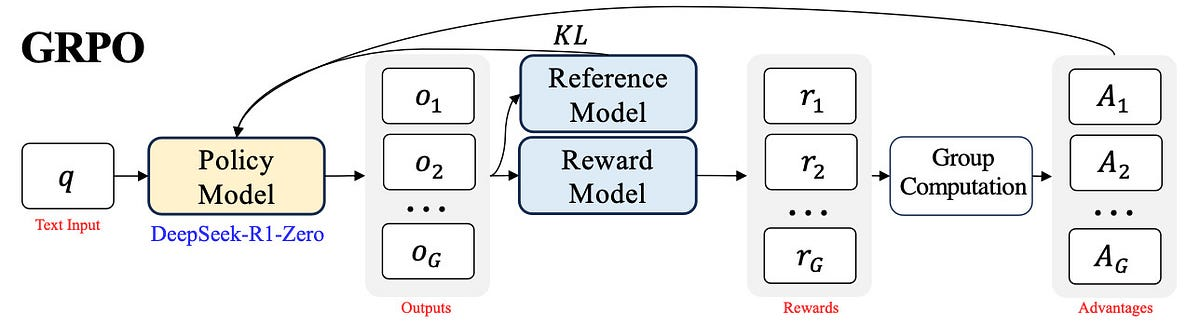


GRPOを効果的に機能させるためには、まずモデルに基本的な回答フォーマットを学習させる必要があります。
これをスキップすると、モデルが適切な形式で回答を生成できず、報酬関数が正しく機能しません。
そのため、以下の流れで学習を行います：

1. **SFT（Supervised Fine-Tuning）**: 少量のデータで正しい回答フォーマットを学習
2. **GRPO**: 強化学習で回答の質を向上

##必要なライブラリのインストール
※結構長いです．最後の方にエラーがでますが，一旦は無視できるので，ほっといて下さい()

今回は学習ライブラリとしてunslothを使います．シングルGPUに最適化した超高速学習ライブラリです．GRPOは仕組み上推論も同時に行うオンライン強化学習なので，推論ライブラリのvllmを使います．unslothは標準でvllmをサポートしており，公式でもこのセットが推奨されています．

※以下のインストールセルはipythonのカーネル再起動を要求することがあります．その通りセッションを再起動して再度実行してください．


In [1]:
!pip install --no-deps unsloth vllm==0.8.5.post1

import sys, re, requests; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install math-verify[antlr4_13_2]
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer pyyaml

# vLLMの公式要件ファイルを取得
f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
with open("vllm_requirements.txt", "wb") as file:
    file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f)) # 競合箇所の削除
!pip install -r vllm_requirements.txt
# 暫定対応として追加
# 途中で聞かれるY/nは全てYを選択する
!pip uninstall -y trl unsloth unsloth_zoo
!pip install trl==0.19.1 unsloth==2025.7.8 unsloth_zoo==2025.7.10

Ignoring outlines: markers 'platform_machine == "s390x"' don't match your environment
Ignoring importlib_metadata: markers 'python_version < "3.10"' don't match your environment
  Using cached outlines_core-0.2.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached xgrammar-0.1.21-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached compressed_tensors-0.11.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached depyf-0.19.0-py3-none-any.whl.metadata (7.3 kB)
Using cached outlines_core-0.2.10-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
Using cached xgrammar-0.1.21-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
Using cached compressed_tensors-0.11.0-py3-none-any.whl (179 kB)
Using cached depyf-0.19.0-py3-none-any.whl (39 kB)
  Attempting uninstall: outlines_core
    Found existing installation: outlines_core 0.1.26
    Uninstalling outlines_core-0.1.26:
      Successfu

In [2]:
!pip install vllm
!pip install -U datasets
!pip install fsspec==2023.9.2

!pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
!pip install --no-deps unsloth

!pip install groq

  Using cached xgrammar-0.1.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.6 kB)
  Using cached compressed_tensors-0.9.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached depyf-0.18.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached xformers-0.0.29.post2-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (1.2 kB)
  Using cached outlines_core-0.1.26-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached compressed_tensors-0.9.3-py3-none-any.whl (98 kB)
Using cached depyf-0.18.0-py3-none-any.whl (38 kB)
Using cached xformers-0.0.29.post2-cp312-cp312-manylinux_2_28_x86_64.whl (44.3 MB)
Using cached xgrammar-0.1.18-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.8 MB)
Using cached outlines_core-0.1.26-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (343 kB)
  Attempting uninstall: depyf
    Found existing installation: depyf 0.19.0
    Uninstalling depyf-0.19.0:
      Successfully uninstalled depyf-0.19.0
 

In [3]:
!pip list

Package                                  Version
---------------------------------------- -------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.10.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.12.15
aiosignal                                1.4.0
airportsdata                             20250811
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
altair                                   5.5.0
annotated-types                          0.7.0
antlr4-python3-runtime                   4.13.2
anyio                                    4.10.0
anywidget                                0.9.18
argon2-cffi                              25.1.0
argon2-cffi-bindings           

huggingfaceのトークンを認証しておきます．
トークンの取得方法は下記を参照してください．
https://zenn.dev/protoout/articles/73-hugging-face-setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
from huggingface_hub import login
import wandb

HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)

WANDB_API_KEY = userdata.get('wandb')
wandb.login(key=WANDB_API_KEY)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: haraguchi (haraguchi-chiba-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [11]:
# !huggingface-cli login

In [5]:
!git config --global credential.helper store

In [13]:
# !wandb login --relogin

In [6]:
import torch
import numpy as np
from datasets import load_dataset
from unsloth import FastLanguageModel
from transformers import TextStreamer
from trl import GRPOConfig, GRPOTrainer, SFTTrainer, SFTConfig
from vllm import SamplingParams
from math_verify import parse, verify
import re

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 08-23 10:32:57 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 08-23 10:32:57 [__init__.py:239] Automatically detected platform cuda.


###諸々のconfigの準備

In [7]:
MAX_SEQ_LENGTH = 2048 # モデルの取り扱うことのできるコンテキストの最大量を設定します．
# MAX_SEQ_LENGTH = 4096
LORA_RANK = 64# LoRAのハイパーパラメータです．更新パラメータの量を決めます．
MODEL_NAME = "unsloth/Qwen3-4B"# unslothの用意した専用モデルです．基本これを使うことが推奨されています．
RUN_NAME = "Drgrpo_2048_verify_plus_groq" # 各自自分の実験だとわかるように書き換えてください。
LEARNED_MODEL_NAME = "hara-CU/minicompe-model" #学習したモデルを保存するHFのレポジトリです

In [8]:
# wandbの設定
import wandb

WANDB_PROJECT = "minicomp-test2"
# RUN_NAME = "test" # 各自自分の実験だとわかるように書き換えてください。
wandb.init(
    project=WANDB_PROJECT,
    name=RUN_NAME,
)

##モデルとトークナイザーの準備

今回はUnslothのFastLanguageModelを使ってモデルをロードし，それに対してLoRA学習のためのアダプターをガッチャンします．

LoRAとはLLMのtransformerアーキテクチャにおける各層に対して追加のパラメータをアダプター的にくっつけて，そこだけ学習するという手法です．使用するGPUのvramを全層を学習するより少なく済みます．

In [9]:
def prepare_model_and_tokenizer():
    """モデルとトークナイザーを準備"""
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name=MODEL_NAME,
        max_seq_length=MAX_SEQ_LENGTH,
        load_in_4bit=False,
        fast_inference=True,  # vLLM高速推論を有効化
        max_lora_rank=LORA_RANK,
        gpu_memory_utilization=0.8,
    )

    # LoRAアダプターの追加
    model = FastLanguageModel.get_peft_model(
        model,
        r=LORA_RANK,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj",
        ],# アダプターはLLMの線形層につけますが，ここでは一般的なところにつけときます．
        lora_alpha=LORA_RANK * 2,
        use_gradient_checkpointing="unsloth", # 勾配更新の計算方法ですね．unslothは独自のgradient_checkpoingの手法を持っています．
        random_state=3407,
    )

    return model, tokenizer

## SFTのデータセットの準備

SFTでは、モデルに正しい回答フォーマットを学習させます。
Qwen3は<think>タグで思考過程を記述するreasoningモードを持っているので、ここでの効果はそこまでありませんが，一般にはSFTを活用してフォーマットを学習させます。

今回はMiroMindのデータセットをサンプリングして使います．

In [10]:
def prepare_sft_dataset():
    """SFT用のデータセットを準備（少量のサンプル）"""
    dataset = load_dataset("miromind-ai/MiroMind-M1-SFT-719K", split="train")

    # 少量のサンプルだけを使用（100件程度）
    dataset = dataset.select(range(min(1000, len(dataset))))

    def format_sft_data(example):
        """SFT用のフォーマット：問題と解答のペアを作成"""
        messages = [
            {"role": "user", "content": example["question"]},
            {"role": "assistant", "content": example['response']}
        ]

        # chat_templateを適用してテキスト化.Qwenではこのタイミングで勝手に
        text = tokenizer.apply_chat_template(messages, tokenize=False)
        return {"text": text}

    # データセットをフォーマット
    formatted_dataset = dataset.map(format_sft_data)

    # # トークン長でフィルタリング（長すぎるものを除外）
    # def filter_by_length(example):
    #     return len(tokenizer.encode(example["text"])) <= MAX_SEQ_LENGTH // 2
    # formatted_dataset = formatted_dataset.filter(filter_by_length)
    # ↑　これはやってもいいですが，max_tokenを超えた分についてはあとでtruncateされます．

    return formatted_dataset

## trainerの定義と実行



In [11]:
def train_sft(model, tokenizer, sft_dataset, sft_config):
    """SFTでフォーマットを学習"""

    # SFTトレーナーの作成と実行
    sft_trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=sft_dataset,
        args=sft_config,
    )

    print("#########学習開始#########")
    sft_trainer.train()

    return model

### GRPOのデータセットを準備

今回はnvidiaのAIME攻略用の数学データセットを使います．
unslothがサイズを小さくしたものを用意してくれているので，そのまま使います．ついでにprompt状態にしておきましょう．



In [12]:
def prepare_grpo_dataset(SYSTEM_PROMPT):
    """GRPOトレーニング用のデータセットを準備"""
    dataset = load_dataset("unsloth/OpenMathReasoning-mini", split="cot")

    """ データセットのフォーマット（シンプルな形式）
    今回はシステムプロンプトなし＋問題のプロンプトにします．Qwen3はOpenAIのmessage形式のchattemplateの対応しているので，以下のようにpromptを用意しておきます．
    Qwen3はシステムプロンプト無しを推奨しているようです．
    """
    def format_grpo_data(example): # 修正
        return {
            "prompt": [
                {"role": "user", "content": example["problem"]},
            ],
            "answer": example["expected_answer"],
        }

    dataset = dataset.map(format_grpo_data)
    return dataset

## trainerの定義と実行

unslothでもtrlやtransfomersなどと同様にtrainerを作って学習を回します．てか，基本trlをラップしているライブラリなんでそうなんですが．

今回はプロンプトの時点で最大トークンを超えている場合はそのデータはfilterしておく設定にしています．

またQwen3はデフォルトでReasoningモードになっていることに注意です．

In [13]:
def train_grpo(model, tokenizer, dataset, reward_funcs, grpo_config):
    """GRPOトレーニングを実行（reasoning mode有効）"""

    trainer = GRPOTrainer(
        model=model,
        processing_class=tokenizer,
        reward_funcs=reward_funcs,
        args=grpo_config,
        train_dataset=dataset,
    )

    print("#########学習開始#########")
    trainer.train()
    return model

## メインの実行処理

In [14]:
print("1. モデル準備...")
model, tokenizer = prepare_model_and_tokenizer()

1. モデル準備...
Unsloth: Patching vLLM v1 graph capture
Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.7.8: Fast Qwen3 patching. Transformers: 4.55.2. vLLM: 0.8.5.post1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/Qwen3-4B with actual GPU utilization = 79.08%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 24.22 GB. Also swap space = 6 GB.
INFO 08-23 10:33:48 [config.py:717] This model supports multiple tasks: {'score', 'generate', 'reward', 'embe

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

INFO 08-23 10:33:53 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='unsloth/Qwen3-4B', speculative_config=None, tokenizer='unsloth/Qwen3-4B', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda:0, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=unsloth/Qwen3-4B, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_prefix_caching=True, chunked_prefill_enabled=True, use_async_output_proc=T

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

INFO 08-23 10:34:17 [weight_utils.py:281] Time spent downloading weights for unsloth/Qwen3-4B: 22.495518 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 08-23 10:34:20 [loader.py:458] Loading weights took 2.38 seconds
INFO 08-23 10:34:20 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 08-23 10:34:20 [gpu_model_runner.py:1347] Model loading took 7.7584 GiB and 25.891201 seconds
INFO 08-23 10:34:41 [backends.py:420] Using cache directory: /root/.cache/vllm/torch_compile_cache/fe69ad95aa/rank_0_0 for vLLM's torch.compile
INFO 08-23 10:34:41 [backends.py:430] Dynamo bytecode transform time: 20.37 s


Unsloth: Compiling kernels: 100%|██████████| 6/6 [00:00<00:00, 73.79it/s, triton_poi_fused_add_mul_sub_5]

INFO 08-23 10:35:04 [backends.py:136] Cache the graph of shape None for later use



Unsloth: Compiling kernels: 100%|██████████| 5/5 [00:00<00:00, 75.64it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 08-23 10:36:27 [backends.py:148] Compiling a graph for general shape takes 102.36 s


INFO 08-23 10:36:37 [monitor.py:33] torch.compile takes 122.73 s in total
INFO 08-23 10:36:38 [kv_cache_utils.py:634] GPU KV cache size: 154,528 tokens
INFO 08-23 10:36:38 [kv_cache_utils.py:637] Maximum concurrency for 2,048 tokens per request: 75.45x
INFO 08-23 10:36:38 [vllm_utils.py:641] Unsloth: Running patched vLLM v1 `capture_model`.
INFO 08-23 10:37:11 [gpu_model_runner.py:1686] Graph capturing finished in 34 secs, took 0.84 GiB
INFO 08-23 10:37:11 [vllm_utils.py:648] Unsloth: Patched vLLM v1 graph capture finished in 34 secs.
INFO 08-23 10:37:13 [core.py:159] init engine (profile, create kv cache, warmup model) took 172.47 seconds
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm']


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.7.8 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


### SFTの学習します

In [15]:
print("SFT用データセット準備中...")
sft_dataset = prepare_sft_dataset()

SFT用データセット準備中...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

train-00000-of-00022.parquet:   0%|          | 0.00/270M [00:00<?, ?B/s]

train-00001-of-00022.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

train-00002-of-00022.parquet:   0%|          | 0.00/250M [00:00<?, ?B/s]

train-00003-of-00022.parquet:   0%|          | 0.00/269M [00:00<?, ?B/s]

train-00004-of-00022.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00005-of-00022.parquet:   0%|          | 0.00/206M [00:00<?, ?B/s]

train-00006-of-00022.parquet:   0%|          | 0.00/170M [00:00<?, ?B/s]

train-00007-of-00022.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

train-00008-of-00022.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

train-00009-of-00022.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

train-00010-of-00022.parquet:   0%|          | 0.00/172M [00:00<?, ?B/s]

train-00011-of-00022.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

train-00012-of-00022.parquet:   0%|          | 0.00/169M [00:00<?, ?B/s]

train-00013-of-00022.parquet:   0%|          | 0.00/172M [00:00<?, ?B/s]

train-00014-of-00022.parquet:   0%|          | 0.00/171M [00:00<?, ?B/s]

train-00015-of-00022.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

train-00016-of-00022.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00017-of-00022.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00018-of-00022.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

train-00019-of-00022.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

train-00020-of-00022.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00021-of-00022.parquet:   0%|          | 0.00/220M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/719232 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [16]:

# SFTの設定
sft_config = SFTConfig(
    dataset_text_field="text",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    warmup_ratio=0.1,
    num_train_epochs=2, # LLMのSFTだと一般的ですかね．
    learning_rate=2e-5,
    logging_steps=5,
    optim="adamw_torch",
    weight_decay=0.01,
    lr_scheduler_type="linear",
    seed=3407,
    output_dir="outputs_sft",
    report_to="wandb"
)


In [17]:
print("\n=== 2. SFT（教師あり学習）フェーズ ===")
print("まず、正しい回答フォーマットを学習させます...")
model = train_sft(model, tokenizer, sft_dataset, sft_config)


=== 2. SFT（教師あり学習）フェーズ ===
まず、正しい回答フォーマットを学習させます...


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

#########学習開始#########


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 2 | Total steps = 500
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 2 x 1) = 4
 "-____-"     Trainable parameters = 132,120,576 of 4,154,588,672 (3.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
5,0.625800
10,0.582000
15,0.610200
20,0.565000
25,0.535600
30,0.560500
35,0.516200
40,0.494600
45,0.454400
50,0.483600


wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


In [18]:
# 学習後のテスト
print("\n### SFT後のテスト生成 ###")
test_prompt = [{"role": "user", "content": "What is 15 + 23?"}]
inputs = tokenizer.apply_chat_template(
    test_prompt,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

with torch.no_grad():
    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=512,
        temperature=0.1,
        do_sample=True,
        top_p=0.95,
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=False)
print("生成例:")
print(response)
print("\n正しくreasoningフォーマットで生成できているか確認してください。")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



### SFT後のテスト生成 ###
生成例:
<|im_start|>user
What is 15 + 23?<|im_end|>
<|im_start|>assistant
<think>
Okay, let's see. The problem is 15 plus 23. Hmm, I need to add these two numbers together. Let me start by breaking them down. 15 is 10 plus 5, and 23 is 20 plus 3. So if I add the tens first, 10 plus 20 is 30. Then the ones: 5 plus 3 is 8. So 30 plus 8 is 38. Wait, that seems right. Let me check another way. Maybe counting up from 15. 15 plus 10 is 25, then plus 13 more would be 38. Yeah, that matches. Or maybe using a number line. Starting at 15, moving 20 to the right gets me to 35, then 3 more makes 38. All the methods point to 38. I think that's the correct answer.
</think>

15 + 23 = 38<|im_end|>

正しくreasoningフォーマットで生成できているか確認してください。


In [19]:
# メモリ解放
if 'sft_trainer' in locals(): # 修正
    del sft_trainer
torch.cuda.empty_cache()
torch.cuda.ipc_collect()  # 修正

### GRPO学習します．

今回はmaxstepを100にしているので，100step(設定上実質バッチサイズは8なので，データセットのうち800件で学習したことになります．)

In [20]:

print("\n=== 3. GRPO（強化学習）フェーズ ===")
print("GRPOデータセット準備中...")
# Add a placeholder SYSTEM_PROMPT as it's a required argument
grpo_dataset = prepare_grpo_dataset(SYSTEM_PROMPT="") # 修正

# トークン長を計算（enable_thinking=Trueで）
def get_token_length(example):
    return len(tokenizer.apply_chat_template(
        example["prompt"],
        add_generation_prompt=True,
        tokenize=True,
    ))

grpo_dataset = grpo_dataset.map(lambda x: {"token_length": get_token_length(x)})
max_prompt_length = int(np.quantile(grpo_dataset["token_length"], 0.9))
grpo_dataset = grpo_dataset.filter(lambda x: x["token_length"] <= max_prompt_length)

MAX_STEP = 100
grpo_config = GRPOConfig(
    temperature=0.6, # Qwen3の推奨値
    learning_rate=5e-6, #LoRAなんでやや高めで．
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    num_generations=4, # 同時に生成するサンプル数です．基本4以上が推奨です．ここを2にするとオンラインDPOを同じようなことをやっていることになります(lossの仕組みとか違いますが)
    max_prompt_length=max_prompt_length,
    max_completion_length=MAX_SEQ_LENGTH - max_prompt_length,
    max_steps = MAX_STEP,
    save_steps=100,
    loss_type="dr_grpo",
    output_dir="outputs",
    report_to="wandb"
)


=== 3. GRPO（強化学習）フェーズ ===
GRPOデータセット準備中...


README.md:   0%|          | 0.00/603 [00:00<?, ?B/s]

data/cot-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

Generating cot split:   0%|          | 0/19252 [00:00<?, ? examples/s]

Map:   0%|          | 0/19252 [00:00<?, ? examples/s]

Map:   0%|          | 0/19252 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19252 [00:00<?, ? examples/s]

Unsloth: The Dr GRPO paper recommends setting `scale_rewards` to False! Will override. Set it to `None` to force False.
Unsloth: We now expect `per_device_train_batch_size` to be a multiple of `num_generations`.
We will change the batch size of 1 to the `num_generations` of 4


In [21]:
max_prompt_length

95

In [22]:
#@title reward_funcの引数
"""
reward_func args: []
reward_func kwargs:
{'prompts': 'list(len=32)',
'completions': 'list(len=32)',
'completion_ids': 'list(len=32)',
'expected_answer': 'list(len=32)',
'problem_type': 'list(len=32)',
 'problem_source': 'list(len=32)',
 'generation_model': 'list(len=32)',
 'pass_rate_72b_tir': 'list(len=32)',
  'problem': 'list(len=32)',
   'generated_solution': 'list(len=32)',
   'inference_mode': 'list(len=32)',
   'answer': 'list(len=32)',
    'token_length': 'list(len=32)'}

"""

"\nreward_func args: []\nreward_func kwargs:\n{'prompts': 'list(len=32)',\n'completions': 'list(len=32)',\n'completion_ids': 'list(len=32)',\n'expected_answer': 'list(len=32)',\n'problem_type': 'list(len=32)',\n 'problem_source': 'list(len=32)',\n 'generation_model': 'list(len=32)',\n 'pass_rate_72b_tir': 'list(len=32)',\n  'problem': 'list(len=32)',\n   'generated_solution': 'list(len=32)',\n   'inference_mode': 'list(len=32)',\n   'answer': 'list(len=32)',\n    'token_length': 'list(len=32)'}\n\n"

In [24]:
#@title 報酬関数設計


import re
import numpy as np
from math_verify import parse, verify
from sympy import sympify, simplify, N, expand, factor, trigsimp, lambdify
import math
from itertools import zip_longest



def math_verify_score(gold_answer,cleaned_response):
    if verify(parse(gold_answer), parse(cleaned_response)):
        score = 1.0
    else:
      score = 0

    return score



# -----------------------------
# Groq API スコアリング関数
# -----------------------------

from groq import Groq
from google.colab import userdata
import requests


GROQ_model = "qwen/qwen3-32b"

GROQ_API_KEY = userdata.get('Groq_API_KEY')
url = "https://api.groq.com/openai/v1/chat/completions"

def Groq_api(content,model_name):

  client = Groq(api_key=GROQ_API_KEY)
  completion = client.chat.completions.create(
      model=model_name,
      messages=[
          {
              "role": "user",
              "content": content,
          }
      ]
  )
  # print(completion.choices[0].message.content)


  return completion.choices[0].message.content


def complete_content_GRPO_judge(response, gold_answer):
  contents = (
f"""
Your role is to evaluate the model's answer by comparing it to the reference (gold) answer.
Please assign a score out of 100 points according to the following grading criteria.

[Grading Criteria]
- The maximum score is 100.
- Only the final answer in the model's response should be evaluated.
- The reasoning or calculation process in the model's response should not be considered when grading.
- If the final answer and the gold answer are semantically equivalent, the answer should be considered correct, even if the format differs.
- If the final answer differs from the gold answer but is close, partial credit may be awarded.

Respond strictly in the following format:

★Score: XX
(XX is an integer. Grade out of 100 points)

---

[Model Answer]
{response}

[Gold Answer]
{gold_answer}
"""
)

  return contents

def extract_score_from_API_judge(text):
    # 正規表現で ★Score: に続く半角の整数（最大3桁）を抽出
    match = re.search(r'★Score[:：]\s*(\d{1,3})', text)
    if match:
        try:
            score = int(match.group(1))
            if 0 <= score <= 100:
                return score / 100
        except ValueError:
            pass
    return 0


def Groq_api_scoring(response, gold_answer,model_name):
    content = complete_content_GRPO_judge(response, gold_answer)
    scoring_text = Groq_api(content,model_name)
    score = extract_score_from_API_judge(scoring_text)

    return score

# -----------------------------
# 長さペナルティ
# -----------------------------
def calc_length_penalty(completion_length, max_length, start_ratio=0.85):
    L_start = start_ratio * max_length
    max_length = max_length + 100
    if completion_length <= L_start:
        return 1.0
    elif completion_length >= max_length:
        return 0.0
    else:
        ratio = (completion_length - L_start)/(max_length - L_start)
        return 0.5*(1 + np.cos(np.pi*ratio))

# -----------------------------
# 短答ボーナス 満点回答のみ
# -----------------------------
def reward_length_rank_bonus(base_scores, token_lengths):
    # 満点回答のインデックス
    full_idx = [i for i, s in enumerate(base_scores) if s >= 1.0]
    n = len(full_idx)
    if n == 0:
        return base_scores

    # 満点回答の平均長さ
    mean_length = np.mean([token_lengths[i] for i in full_idx])

    # 平均に近い順にソート
    ranked = sorted(full_idx, key=lambda i: abs(token_lengths[i] - mean_length))

    final_scores = base_scores.copy()
    for rank, i in enumerate(ranked):
        bonus = 1 - rank / n
        final_scores[i] += bonus  # スコアに加算

    return final_scores

# -----------------------------
# 報酬関数（verifyで採点、0点をGroqで採点して補強 + 短答報酬 適用）
# -----------------------------
def reward_verify_plus_groq(prompts, completions, expected_answer, token_length,
                            numeric_points=None, max_penalty=10, expr_weight=1.0,
                            tau=0.1, min_score=0.2, max_seq_length=MAX_SEQ_LENGTH, pair_weight=1.0,
                            **kwargs):
    # batch_size = len(completions)
    scores = []
    correct_flags = []

    for completion, gold_answer, comp_len in zip(completions, expected_answer, token_length):
        response = completion[0]["content"]
        length_penalty = calc_length_penalty(comp_len, max_seq_length)
        length_penalty = 1

        # thinkタグ形式チェック
        if not re.search(r'<think>.*?</think>', response, flags=re.DOTALL):
            score = 0.1 if re.search(r'<think>|</think>', response, flags=re.DOTALL) else 0.0
            score *= length_penalty
            scores.append(score)
            continue

        cleaned_response = re.sub(r'<think>.*?</think>', '', response, flags=re.DOTALL)
        # cleaned_response = re.sub(r'<\|im_end\|>', '', cleaned_response)

        # スコアリング
        verify_score = math_verify_score(cleaned_response, gold_answer)
        groq_score = 0
        if verify_score != 1.0:
            groq_score = Groq_api_scoring(cleaned_response, gold_answer,GROQ_model)

        partial_score = max(verify_score, groq_score)
        partial_score = min(partial_score, 1.0)
        score = max(partial_score, min_score) * length_penalty

        scores.append(score)

    # scores = reward_length_rank_bonus(scores, token_length)

    return scores



In [25]:
reward_funcs = [reward_verify_plus_groq]

In [ ]:
print("3. GRPO学習開始...")

model = train_grpo(model, tokenizer, grpo_dataset, reward_funcs, grpo_config)

3. GRPO学習開始...
#########学習開始#########


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 17,326 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 132,120,576 of 4,154,588,672 (3.18% trained)


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / reward_verify_plus_groq / mean,rewards / reward_verify_plus_groq / std
1,0.000200,0.315625,0.116042,1900.437500,1339.000000,1953.000000,0.875000,1532.500000,1339.000000,1879.000000,0.202743,0.315625,0.369925
2,0.000100,0.215625,0.006250,1886.125000,1288.000000,1953.000000,0.875000,1418.000000,1288.000000,1595.000000,0.142126,0.215625,0.301726
3,0.000100,0.159375,0.061555,1953.000000,1953.000000,1953.000000,1.000000,0.000000,0.000000,0.000000,0.134051,0.159375,0.221227
4,-0.005200,0.212500,0.112500,1900.906250,1143.000000,1953.000000,0.875000,1536.250000,1143.000000,1941.000000,0.185275,0.212500,0.302410


In [ ]:
# テスト（reasoning modeで）
test_prompt = [{"role": "user", "content": "What is 25 + 37?"}]
inputs = tokenizer.apply_chat_template(
  test_prompt,
  tokenize=True,
  add_generation_prompt=True,
  return_tensors="pt"
).to("cuda")

print("\nReasoning mode出力例:")
outputs = model.generate(
  input_ids=inputs,
  max_new_tokens=2048,
  temperature=0.6,
  streamer=TextStreamer(tokenizer, skip_prompt=True),
)

In [ ]:
model = model.merge_and_unload()

In [ ]:
model.push_to_hub(LEARNED_MODEL_NAME, revision=RUN_NAME)
tokenizer.push_to_hub(LEARNED_MODEL_NAME, revision=RUN_NAME)

# 評価環境の構築
- セッションが切れてしまった場合に、HFへのモデルのアップロードが終了していれば、インストール、HFとWandBへのログイン、sft_configとgrpo_configを設定するセルを再実行することで、以下を再実行できます。

In [ ]:
%%bash
# 評価環境の作成

git clone https://github.com/Haraguchi-T/minicomp-codes.git
cd minicomp-codes
cd evaluation

bash install.sh

In [ ]:
import json
report_sft_key = {"dataset_text_field",
        "per_device_train_batch_size",
        "gradient_accumulation_steps",
        "warmup_ratio",
        "num_train_epochs",
        "learning_rate",
        "logging_steps",
        "optim",
        "weight_decay",
        "lr_scheduler_type",
        "seed"}
report_grpo_key = {"temperature",
        "learning_rate",
        "per_device_train_batch_size",
        "gradient_accumulation_steps",
        "num_generations",
        "max_prompt_length",
        "max_completion_length",
        "max_steps"}
output_sft_config = {key: value for key, value in sft_config.to_dict().items() if key in report_sft_key}
output_grpo_config = {key: value for key, value in grpo_config.to_dict().items() if key in report_grpo_key}
output_grpo_config["reward_funcs"] = "--".join([func.__name__ for func in reward_funcs])

configs = {
    "run_name": RUN_NAME,
    "base_model_name": MODEL_NAME,
    "sft_config": output_sft_config,
    "grpo_config": output_grpo_config,
    "model_name": LEARNED_MODEL_NAME,
}

eval_code_path = "./minicomp-codes/evaluation"

with open(f"{eval_code_path}/train_configs.json", "w") as f:
    json.dump(configs, f)


In [ ]:
import yaml
with open(f"{eval_code_path}/eval_config.yaml", "r") as f:
    eval_config = yaml.safe_load(f)

eval_config["model_parameters"]["model_name"] = LEARNED_MODEL_NAME
eval_config["model_parameters"]["revision"] = RUN_NAME
with open(f"{eval_code_path}/eval_config.yaml", "w") as f:
    yaml.dump(eval_config, f)


In [ ]:
import gc, torch

if 'grpo_trainer' in locals(): # 修正
    del grpo_trainer
if "model" in locals():
  del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()  # 修正

# 評価の実行とwandbへのアップロード
- GPUメモリが足りない場合があります。その場合はセッション再起動をして、ここからやり直してください。

In [ ]:
%%bash
nvidia-smi

In [ ]:
%%bash
cd ./minicomp-codes/evaluation
bash run.sh

INFO 08-23 09:46:05 [__init__.py:244] Automatically detected platform cuda.
|      Task       |Version|     Metric     |Value |   |Stderr|
|-----------------|------:|----------------|-----:|---|-----:|
|all              |       |extractive_match|0.8059|±  |0.0109|
|lighteval:gsm8k:0|      0|extractive_match|0.8059|±  |0.0109|

INFO 08-23 09:53:13 [__init__.py:244] Automatically detected platform cuda.
|       Task       |Version|        Metric        |Value |   |Stderr|
|------------------|------:|----------------------|-----:|---|-----:|
|all               |       |math_pass@1:1_samples |0.0333|±  |0.0333|
|                  |       |math_pass@1:4_samples |0.0083|±  |0.0083|
|                  |       |math_pass@1:8_samples |0.0125|±  |0.0092|
|                  |       |math_pass@1:16_samples|0.0104|±  |0.0085|
|                  |       |math_pass@1:32_samples|0.0177|±  |0.0157|
|                  |       |math_pass@1:64_samples|0.0146|±  |0.0126|
|lighteval:aime24:0|      2|math_pa

[2025-08-23 09:46:01,627] [    INFO]: PyTorch version 2.7.0 available. (config.py:54)
[2025-08-23 09:46:08,097] [    INFO]: --- LOADING MODEL --- (pipeline.py:187)
[2025-08-23 09:46:17,724] [    INFO]: This model supports multiple tasks: {'classify', 'embed', 'generate', 'reward'}. Defaulting to 'generate'. (config.py:841)
[2025-08-23 09:46:17,724] [    INFO]: Using max model len 2048 (config.py:1472)
[2025-08-23 09:46:17,726] [    INFO]: Chunked prefill is enabled with max_num_batched_tokens=2048. (config.py:2285)
[2025-08-23 09:46:18,659] [    INFO]: Waiting for init message from front-end. (core.py:526)
[2025-08-23 09:46:18,663] [    INFO]: Initializing a V1 LLM engine (v0.9.2) with config: model='hara-CU/minicompe-model', speculative_config=None, tokenizer='hara-CU/minicompe-model', skip_tokenizer_init=False, tokenizer_mode=auto, revision=Drgrpo_2048_verify_plus_groq_short_length_bonus, override_neuron_config={}, tokenizer_revision=Drgrpo_2048_verify_plus_groq_short_length_bonus, t